In [1]:
# Основные библиотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle   # сохранение модели
%matplotlib inline

# Отладка модели
from sklearn.model_selection import train_test_split

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2


In [2]:
import warnings
warnings.filterwarnings('ignore')

Загрузим данные из файлов csv:

In [3]:
DATASET_PATH_TRAIN = './train.csv'
DATASET_PATH_TEST = './test.csv'
PREPARED_DATASET_PATH_TRAIN = './train_prepared.csv'
PREPARED_DATASET_PATH_TEST = './test_prepared.csv'
PREPARED_DATASET_PATH_VALID = './valid_prepared.csv'
REPORTS_FILE_PATH = './'
PREDICTED_DATASET_PATH_TEST = './test_pred.csv'


train_data = pd.read_csv(DATASET_PATH_TRAIN)
test_data = pd.read_csv(DATASET_PATH_TEST)

Проверим количество пропусков (NaN):

In [4]:
train_data.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [5]:
test_data.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

Заменим пропуски в столбцах их медианными значениями:

In [6]:
train_medians = train_data[['LifeSquare', 'Healthcare_1']].median()
test_medians = test_data[['LifeSquare', 'Healthcare_1']].median()

train_data[['LifeSquare', 'Healthcare_1']] = train_data[['LifeSquare', 'Healthcare_1']].fillna(train_medians)
test_data[['LifeSquare', 'Healthcare_1']] = test_data[['LifeSquare', 'Healthcare_1']].fillna(test_medians)

Проверим, удалось ли заполнить пропуски:

In [7]:
train_data['LifeSquare'].isna().sum()

0

In [8]:
train_data['Healthcare_1'].isna().sum()

0

In [9]:
test_data['LifeSquare'].isna().sum()

0

In [10]:
test_data['Healthcare_1'].isna().sum()

0

Опимизируем использование памяти для хранения признаков:

In [11]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [12]:
train_data = reduce_mem_usage(train_data)


Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.35 MB
Decreased by 76.9%


In [13]:
test_data = reduce_mem_usage(test_data)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.15 MB
Decreased by 79.6%


Посмотрим, как выглядит распределение нашего таргета:

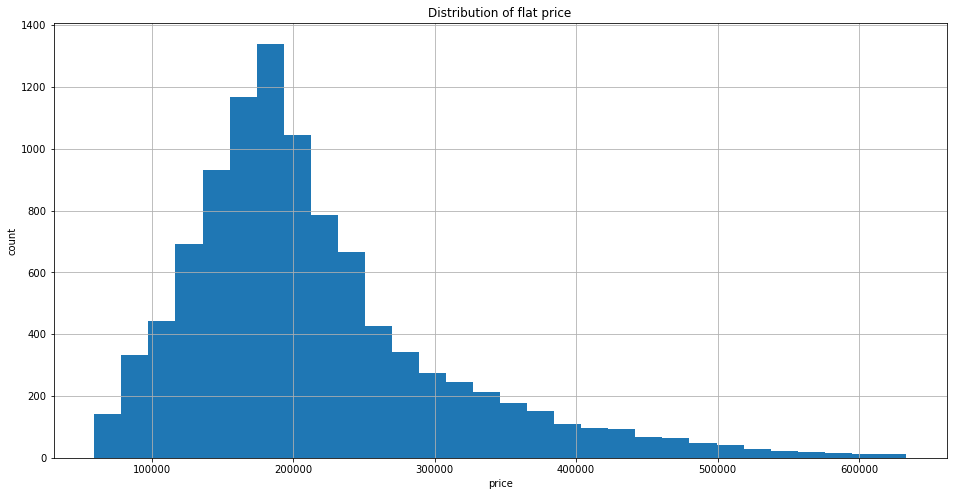

In [14]:
plt.figure(figsize = (16, 8))

train_data['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('price')

plt.title('Distribution of flat price')
plt.show()

Явных выбросов не наблюдается.

Построим матрицу корреляции для всех признаков:

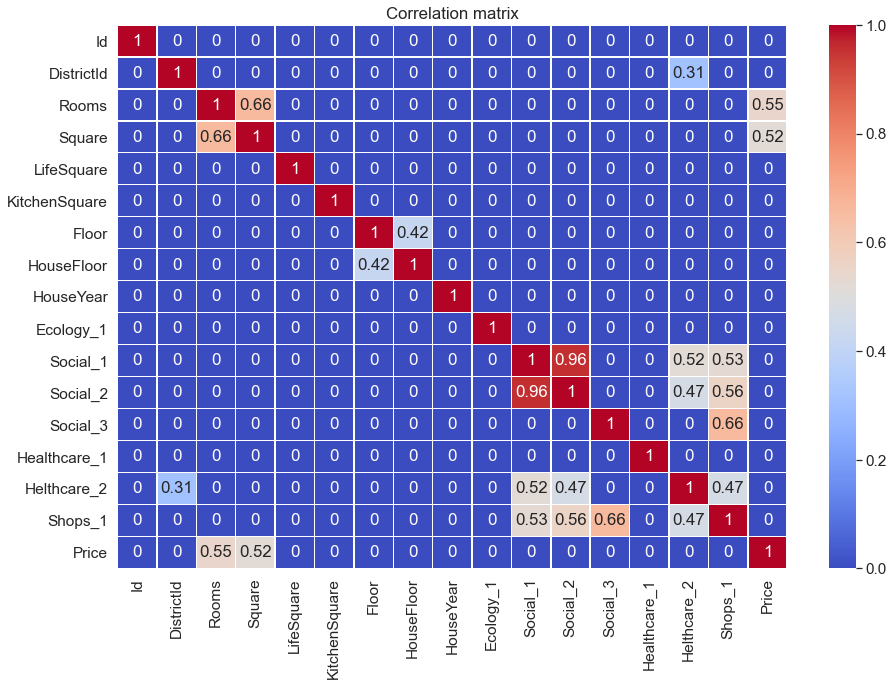

In [15]:
plt.figure(figsize = (15,10))
sns.set(font_scale=1.4)
corr_matrix = train_data.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) <= 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Уберем из нашей выборки столбец "id", т.к. его значения уникальны для каждого наблюдения и не несут полезной информации, а также сохраним этот столбец от датасета test_data отдельно для последующего оформления ответа для kaggle:

In [16]:
train_data = train_data[train_data.columns[1:]]

test_data_id_column = test_data[test_data.columns[0]]
test_data = test_data[test_data.columns[1:]]

Обработка категориальных признаков
Найдем такие признаки:

In [17]:
train_data.dtypes

DistrictId          int16
Rooms             float16
Square            float16
LifeSquare        float16
KitchenSquare     float16
Floor                int8
HouseFloor        float16
HouseYear           int32
Ecology_1         float16
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float16
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [18]:
train_data['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [19]:
train_data['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [20]:
train_data['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Преобразуем категориальные признаки в бинарный вид при помощи dummy-переменных:

In [21]:
train_data = pd.get_dummies(train_data)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int16  
 1   Rooms          10000 non-null  float16
 2   Square         10000 non-null  float16
 3   LifeSquare     10000 non-null  float16
 4   KitchenSquare  10000 non-null  float16
 5   Floor          10000 non-null  int8   
 6   HouseFloor     10000 non-null  float16
 7   HouseYear      10000 non-null  int32  
 8   Ecology_1      10000 non-null  float16
 9   Social_1       10000 non-null  int8   
 10  Social_2       10000 non-null  int16  
 11  Social_3       10000 non-null  int16  
 12  Healthcare_1   10000 non-null  float16
 13  Helthcare_2    10000 non-null  int8   
 14  Shops_1        10000 non-null  int8   
 15  Price          10000 non-null  float32
 16  Ecology_2_A    10000 non-null  uint8  
 17  Ecology_2_B    10000 non-null  uint8  
 18  Ecology

In [22]:
test_data = pd.get_dummies(test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int16  
 1   Rooms          5000 non-null   float16
 2   Square         5000 non-null   float16
 3   LifeSquare     5000 non-null   float16
 4   KitchenSquare  5000 non-null   float16
 5   Floor          5000 non-null   int8   
 6   HouseFloor     5000 non-null   float16
 7   HouseYear      5000 non-null   int16  
 8   Ecology_1      5000 non-null   float16
 9   Social_1       5000 non-null   int8   
 10  Social_2       5000 non-null   int16  
 11  Social_3       5000 non-null   int16  
 12  Healthcare_1   5000 non-null   float16
 13  Helthcare_2    5000 non-null   int8   
 14  Shops_1        5000 non-null   int8   
 15  Ecology_2_A    5000 non-null   uint8  
 16  Ecology_2_B    5000 non-null   uint8  
 17  Ecology_3_A    5000 non-null   uint8  
 18  Ecology_

Из тренировочной выборки выделим таргет, а также разобьем датасет на тренировочный и валидационный:

In [23]:
y = train_data['Price']
X = train_data
del X['Price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)


In [24]:
X_test = test_data

Приведем все числовые признаки к единой размерности (кроме dummy - признаков).
Подготовим список из названий столбцов, которые собираемся стандартизировать:

In [25]:
feature_names = list(X_train)
feature_names

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [26]:
feature_names.index('Ecology_2_A')

15

In [27]:
features_for_std = feature_names[:feature_names.index('Ecology_2_A')]

In [28]:
features_for_std

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

Непосредственно сама стандартизация:

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [30]:
X_train_scaled = X_train
X_train_scaled[features_for_std] = scaler.fit_transform(X_train_scaled[features_for_std])
X_train_scaled


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
9069,-0.630091,-1.054837,-0.712975,-0.151436,0.044394,1.049227,0.634289,-0.011829,-0.354434,-1.067393,...,-0.211351,-0.163616,-0.882358,-0.468543,0,1,0,1,0,1
2603,-0.630091,1.317487,5.227522,1.379542,0.162051,-0.674360,-1.409248,-0.011988,-0.874963,-1.294890,...,-0.337040,-0.163616,-0.882358,-0.883079,0,1,0,1,0,1
7738,0.833065,-1.054837,-0.808986,-0.187481,0.044394,-0.865870,0.634289,-0.011950,-0.146505,1.036957,...,-0.337040,-0.163616,-0.210414,0.360527,0,1,0,1,1,0
1579,-0.058546,1.317487,1.938761,0.680021,-0.161504,1.240736,-1.701182,-0.011821,-0.646769,1.207580,...,-0.127557,-0.163616,-0.210414,1.189598,0,1,0,1,0,1
5058,0.604447,1.317487,1.115808,0.087084,0.103223,1.432246,0.634289,-0.011959,1.520012,-0.498650,...,-0.211351,-0.163616,-0.210414,-0.261276,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,-0.470059,0.131325,0.288284,0.285765,-0.161504,-0.865870,-1.555215,-0.011829,-0.993001,-0.157404,...,5.570384,0.032699,1.133473,3.884077,0,1,0,1,0,1
5191,-0.584368,1.317487,1.438893,-0.041230,-0.161504,0.091678,1.802024,-0.011817,-0.405386,1.605700,...,-0.169454,-0.163616,-0.210414,1.396866,0,1,0,1,0,1
5390,-1.133051,1.317487,1.313926,-0.041230,-0.161504,0.857717,0.634289,-0.011988,-0.933604,-1.351764,...,-0.337040,-0.163616,-0.882358,-0.675811,0,1,0,1,0,1
860,0.993098,1.317487,-0.242064,0.000161,-0.043848,-1.440399,-0.533446,-0.012005,0.079952,1.036957,...,-0.211351,-0.163616,1.133473,0.982330,0,1,0,1,0,1


In [31]:
X_test_scaled = X_test
X_test_scaled[features_for_std] = scaler.fit_transform(X_test_scaled[features_for_std])
X_test_scaled

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,0.152140,0.107333,-0.344374,-0.128858,0.002332,-0.480057,0.206083,-0.667299,1.586167,-0.794834,...,-0.304366,-0.168810,-0.891612,-0.888194,0,1,0,1,0,1
1,0.514336,0.107333,0.670478,-0.160279,-0.500230,-0.480057,-1.708911,-0.398066,-0.367043,-1.080052,...,-0.220549,-0.168810,-0.891612,-0.469511,0,1,0,1,0,1
2,3.140252,-1.085258,-2.244359,-1.228101,0.605406,-1.209628,-1.119682,-4.059631,-0.998456,0.288994,...,3.299784,4.793748,2.487242,0.158513,0,1,0,1,0,1
3,-0.096869,0.107333,0.870175,1.033719,0.303869,2.438224,1.384540,1.217331,-0.149964,-0.110311,...,-0.220549,-0.168810,1.135700,-0.260169,0,1,0,1,0,1
4,-0.549613,-1.085258,-0.467139,0.495635,-0.500230,1.526261,0.648004,1.755796,-0.397546,-1.308227,...,-0.304366,-0.168810,-0.891612,-0.888194,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.911809,1.299924,0.559172,0.963022,0.002332,-0.662450,-0.530453,-0.613452,-0.997043,0.631256,...,-0.346275,-0.168810,-0.215841,-0.678852,0,1,0,1,0,1
4996,-1.138181,-1.085258,-0.851801,-0.859396,0.404381,0.614298,0.648004,1.755796,-0.939134,-1.365270,...,-0.346275,-0.168810,-0.891612,-0.678852,0,1,0,1,0,1
4997,-0.889172,1.299924,1.118978,0.803953,0.303869,2.620616,1.384540,0.248093,-0.241981,2.798913,...,-0.262458,-0.168810,2.487242,2.251927,0,1,0,1,0,1
4998,0.242689,0.107333,1.302306,-0.160279,-0.600742,-0.844842,-1.856218,-0.398066,-0.397546,-1.308227,...,-0.304366,-0.168810,-0.891612,-0.888194,0,1,0,1,1,0


In [32]:
X_valid_scaled = X_valid
X_valid_scaled[features_for_std] = scaler.fit_transform(X_valid_scaled[features_for_std])
X_valid_scaled

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
6252,-0.671653,0.128354,-0.337460,-0.049307,-0.165029,-0.669639,-1.137736,-1.165980,-0.724280,0.028775,...,-0.211714,-0.182216,-0.886171,-0.034231,0,1,0,1,0,1
4684,0.253893,1.331670,1.112110,0.676219,0.481298,-0.858839,-1.289354,-1.326867,1.474138,-0.488141,...,-0.211714,-0.182216,-0.222041,-0.244237,0,1,0,1,0,1
1731,-1.018732,1.331670,1.190616,-1.572738,-1.026798,-0.102041,0.681671,-0.415177,1.016293,-1.119927,...,-0.338068,-0.660078,-0.886171,-0.874255,0,1,0,1,0,1
4742,-0.625376,-1.074962,-1.007571,-0.281848,-1.242240,-0.669639,-1.289354,-0.415177,-0.721482,-1.407103,...,-0.338068,-0.182216,-0.886171,-0.874255,0,1,0,1,0,1
4521,0.045645,-1.074962,-0.594009,-0.143874,-1.026798,0.276357,0.681671,-0.415177,2.082562,0.545691,...,-0.295950,-0.381325,0.442089,0.175775,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8014,-0.555960,-1.074962,-0.948691,-0.677942,-0.165029,-1.237237,-1.137736,-1.005094,-1.010433,0.660561,...,-0.253832,2.169928,-0.886171,-0.454243,0,1,0,1,0,1
1074,-0.532821,0.128354,0.478449,-0.143874,-1.026798,-1.237237,0.681671,-0.415177,0.751761,-0.890187,...,-0.338068,-0.182216,-0.886171,-0.664249,0,1,0,1,0,1
3063,-0.602237,0.128354,-0.195868,-0.143874,-1.242240,0.843955,-1.895823,-0.415177,-0.079991,1.464653,...,-0.001123,1.238097,0.442089,-0.244237,0,1,0,1,0,1
6487,0.184477,-1.074962,-0.404752,-0.143874,-1.026798,-1.426437,-1.744206,-0.415177,2.640115,-0.086095,...,-0.211714,0.062025,-0.886171,0.175775,0,1,0,1,0,1


Сохраним подготовленные данные:

In [33]:
X_train_scaled.to_csv(PREPARED_DATASET_PATH_TRAIN, index=False, encoding='utf-8', sep=';')
X_test_scaled.to_csv(PREPARED_DATASET_PATH_TEST, index=False, encoding='utf-8', sep=';')
X_valid_scaled.to_csv(PREPARED_DATASET_PATH_VALID, index=False, encoding='utf-8', sep=';')

Объявим функцию, отображающую основные метрики предсказаний, а также визуализирующую разницу между предсказанными значениями таргета и их истинными значениями.

In [34]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

В ходе отладки с использованием GridSearchCV было установлено, что наилучшие результаты показывает модель RandomForestRegressor.
Лучшие параметры для модели: criterion='mse',
                                 max_depth=10, 
                                 min_samples_leaf=30, 
                                 random_state=42,
                                 n_estimators=400  
                                 

Обучение модели на трейне:

R2:	0.73
RMSE:	48292.757
MSE:	2332190370.035


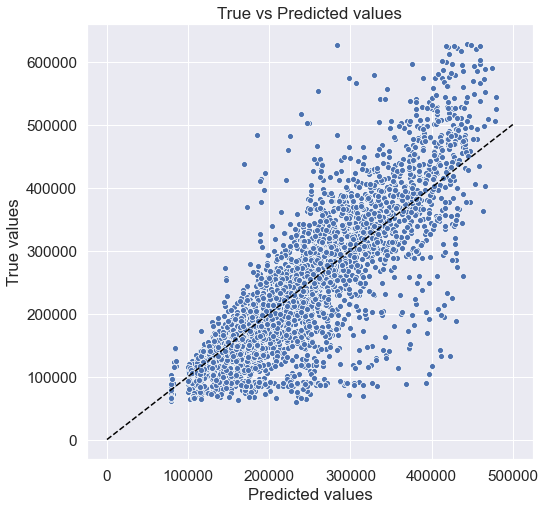

In [35]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=10, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=400  # кол-во деревьев
                                 )

rf_model.fit(X_train_scaled, y_train)
y_train_preds = rf_model.predict(X_train_scaled)
evaluate_preds(y_train, y_train_preds)

Оценка качества предсказания на валидационном датасете:

R2:	0.652
RMSE:	54674.384
MSE:	2989288296.781


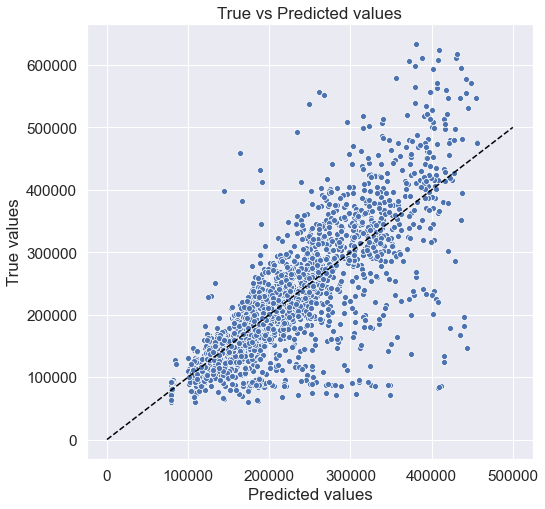

In [36]:
y_valid_preds = rf_model.predict(X_valid_scaled)
evaluate_preds(y_valid, y_valid_preds)

Меня устраивает такая оценка.
Предскажем таргет, используя тестовый датасет.
Сформируем датафрейм для публикаци на Kaggle и сохраним его в формате csv.

In [37]:
y_test_preds = rf_model.predict(X_test_scaled)




In [38]:
ans_data = pd.DataFrame({'Id':test_data_id_column, 'Price':y_test_preds}, columns=['Id', 'Price'])

In [39]:
ans_data.to_csv(PREDICTED_DATASET_PATH_TEST, index=False, encoding='utf-8', sep=',')
